In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold,RepeatedKFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
random_state = 42
np.random.seed(random_state)

## Import the Data

In [ ]:
# definition of each term
des_dict = pd.read_csv("/content/drive/My Drive/AnalyzeThis2020/Data_Dictionary-06_11N.csv",  encoding='cp1252')

In [ ]:
des_dict[11:]['Term']

11           cust_max_credit_12m_amt
12            cust_max_remit_12m_amt
13        cnsumr_lend_tot_util_ratio
14                sum_total_line_amt
15                           cust_id
16                       count_accts
17                            cm_age
18             flag_cust_fee_paid_6m
19                       acq_sub_chn
20                      acq_type_grp
21                      fee_type_grp
22                       Cust_tenure
23                       min_pay_ind
24                  paid_in_full_ind
25                         referrals
26                         spillover
27                        self_accts
28    Customer Low Quality indicator
29         cnsumr_chrg_actv_cust_cnt
30    cnsumr_chrg_avg_credit_12m_amt
31         cnsumr_lend_actv_cust_cnt
32            pre6m_cust_myca_active
33             pre6m_cust_mob_logins
34                  direct_debit_ind
35                       cbr_3_score
36         sow_revol_avg_paydown_pct
37        sow_tot_annual_ext_pmt_amt
3

In [ ]:
description = dict()
for t, d in zip(des_dict[11:]['Term'], des_dict[11:]['Description']):
    description[t] = d


In [ ]:
# load the taining data
def load_train_data():
    data = pd.read_csv("/content/drive/My Drive/AnalyzeThis2020/Training_Data_0611N.csv")
    return data

## Data Exploaration

In [ ]:
df_train = load_train_data()
test = pd.read_csv("/content/drive/My Drive/AnalyzeThis2020/Evaluation_Data_0611_Nv.csv")
print(df_train)

        cust_id  profitable_flag  ...  sow_tot_trans_bal_amt  sow_tot_trans_cnt
0      550391.0              0.0  ...                   -                   3.0
1      550392.0              0.0  ...                   -                   0.0
2      550393.0              0.0  ...                   387                 3.0
3      550394.0              0.0  ...                   295                 4.0
4      550395.0              0.0  ...                   143                13.0
...         ...              ...  ...                    ...                ...
19594  569985.0              0.0  ...                    40                 2.0
19595       NaN              NaN  ...                    NaN                NaN
19596       NaN              NaN  ...                    NaN                NaN
19597       NaN              NaN  ...                    NaN                NaN
19598       NaN              NaN  ...                    NaN                NaN

[19599 rows x 50 columns]


In [ ]:
df_train.describe()

,cust_id,profitable_flag,count_accts,cm_age,flag_top_ed_spender,flag_cust_fee_paid_6m,pre6m_cust_roc_cnt,pre6m_cust_non_disc_cnt,pre6m_cust_disc_cnt,pre6m_cust_online_cnt,pre6m_cust_travel_cnt,pre6m_cust_retail_cnt,pre6m_cust_myca_active,pre6m_cust_mob_logins,Cust_tenure,pre6m_spend_active_ind,highly_utilized_ind,min_pay_ind,paid_in_full_ind,direct_debit_ind,referrals,spillover,self_accts,Customer Low Quality indicator,cdss_most_rcnt_prob,cbr_3_score,cnsumr_chrg_actv_cust_cnt,cnsumr_lend_actv_cust_cnt,cnsumr_lend_tot_util_ratio,sow_revol_avg_paydown_pct,sow_tot_revol_cnt,sow_tot_trans_cnt
count,19595.000000,19595.000000,19595.000000,19595.000000,19547.000000,19595.000000,19595.000000,19595.000000,19595.000000,19595.000000,19595.000000,19595.000000,19595.000000,19595.000000,19359.000000,19359.000000,19359.000000,19359.000000,19359.000000,19359.000000,19359.000000,19359.000000,19359.000000,19359.000000,19350.000000,19350.000000,19350.000000,19350.000000,19350.000000,19350.000000,19350.000000,19350.000000
mean,560188.000000,0.185966,1.227558,42.700128,0.530874,0.242103,448.679765,142.604134,306.075632,247.239398,88.571370,201.993672,5.476754,32.510589,31.057803,0.933003,0.075314,0.021747,0.590681,0.477246,0.601736,0.220259,0.029185,0.008781,0.007338,1185.215659,0.158966,1.057416,0.133133,0.016669,0.433902,0.787339
std,5656.733598,0.389089,0.515668,11.588827,0.499059,0.428367,531.939134,136.466289,465.602922,762.833133,120.650558,395.731929,4.601415,143.258662,44.098971,0.250024,0.263904,0.145860,0.491721,0.499495,2.439000,1.122721,0.270508,0.093299,0.042707,240.646855,0.373485,0.514165,0.217536,0.059165,1.082492,1.187996
min,550391.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.540188,0.000000,0.000000,0.000000
25%,555289.500000,0.000000,1.000000,34.000000,0.000000,0.000000,126.000000,34.000000,72.000000,48.000000,10.000000,54.000000,3.000000,3.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1118.000000,0.000000,1.000000,0.003551,0.000000,0.000000,0.000000
50%,560188.000000,0.000000,1.000000,39.000000,1.000000,0.000000,348.000000,108.000000,210.000000,156.000000,38.000000,156.000000,5.000000,6.000000,14.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1262.000000,0.000000,1.000000,0.054909,0.000000,0.000000,0.000000
75%,565086.500000,0.000000,1.000000,48.000000,1.000000,0.000000,666.000000,214.000000,444.000000,336.000000,118.000000,294.000000,8.000000,18.000000,37.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.001000,1331.000000,0.000000,1.000000,0.157450,0.000000,0.000000,2.000000
max,569985.000000,1.000000,6.000000,99.000000,1.000000,1.000000,49264.000000,1260.000000,49264.000000,98504.000000,1810.000000,49194.000000,33.000000,7644.000000,550.000000,1.000000,1.000000,1.000000,1.000000,1.000000,235.000000,72.000000,11.000000,1.000000,0.997000,1422.000000,2.000000,5.000000,4.718893,0.498500,10.000000,13.000000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19599 entries, 0 to 19598
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cust_id                         19595 non-null  float64
 1   profitable_flag                 19595 non-null  float64
 2   count_accts                     19595 non-null  float64
 3   cm_age                          19595 non-null  float64
 4   flag_top_ed_spender             19547 non-null  float64
 5   flag_cust_fee_paid_6m           19595 non-null  float64
 6   pre6m_cust_spend                19595 non-null  object 
 7   pre6m_cust_roc_cnt              19595 non-null  float64
 8   pre6m_cust_non_disc_amt         19595 non-null  object 
 9   pre6m_cust_non_disc_cnt         19595 non-null  float64
 10  pre6m_cust_disc_amt             19595 non-null  object 
 11  pre6m_cust_disc_cnt             19595 non-null  float64
 12  pre6m_cust_outbound_amt         

In [ ]:
df_train.dtypes

cust_id                           float64
profitable_flag                   float64
count_accts                       float64
cm_age                            float64
flag_top_ed_spender               float64
flag_cust_fee_paid_6m             float64
pre6m_cust_spend                   object
pre6m_cust_roc_cnt                float64
pre6m_cust_non_disc_amt            object
pre6m_cust_non_disc_cnt           float64
pre6m_cust_disc_amt                object
pre6m_cust_disc_cnt               float64
pre6m_cust_outbound_amt            object
pre6m_cust_online_amt              object
pre6m_cust_online_cnt             float64
pre6m_cust_travel_amt              object
pre6m_cust_travel_cnt             float64
pre6m_cust_retail_amt              object
pre6m_cust_retail_cnt             float64
pre6m_cust_myca_active            float64
pre6m_cust_mob_logins             float64
pre6m_total_mc_trs                 object
acq_sub_chn                        object
acq_type_grp                      

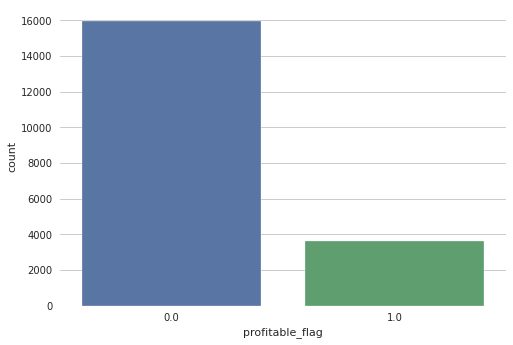

In [ ]:
target = df_train['profitable_flag']
train = df_train.drop(["cust_id", "profitable_flag"], axis=1)
test_df = test.drop(columns=["cust_id"])
sns.set_style('whitegrid')
sns.countplot(target)

-> Skewed data

In [ ]:
features = [c for c in df_train.columns if c not in ['cust_id', 'profitable_flag']]
print("Length of features: ", len(features))

Length of features:  48


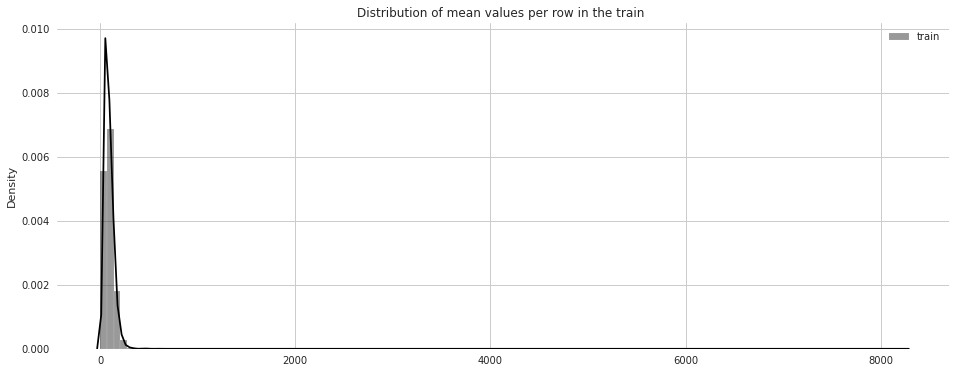

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train ")
sns.distplot(train[features].mean(axis=1),color="black", kde=True,bins=120, label='train')
plt.legend()
plt.show()

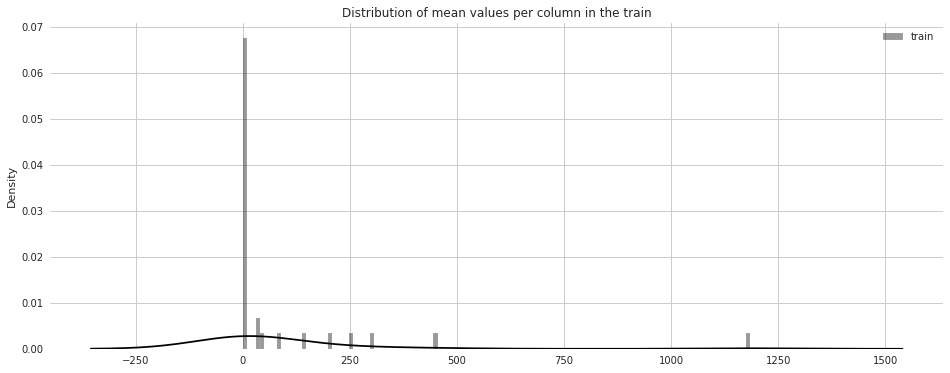

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train")
sns.distplot(train[features].mean(axis=0),color="black", kde=True,bins=120, label='train')

plt.legend();plt.show()

1.0    15880
2.0     3091
3.0      522
4.0       85
5.0       16
6.0        1
Name: count_accts, dtype: int64


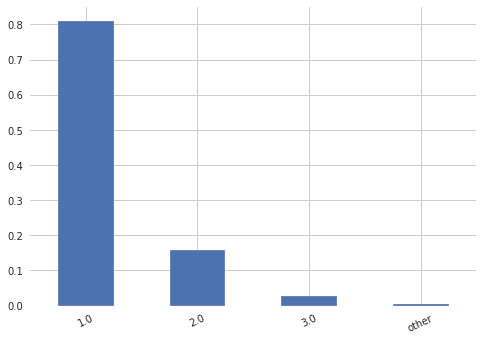

Number of XZVEE accounts of the Customer
****************************************************************************************************
35.0    1045
36.0    1030
34.0    1011
38.0    1011
37.0     999
        ... 
24.0       2
97.0       1
91.0       1
99.0       1
92.0       1
Name: cm_age, Length: 71, dtype: int64


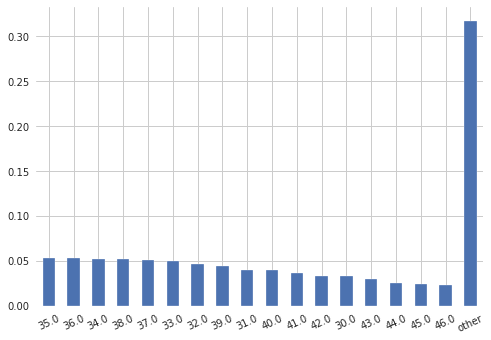

Age of the Customer
****************************************************************************************************
1.0    10377
0.0     9170
Name: flag_top_ed_spender, dtype: int64


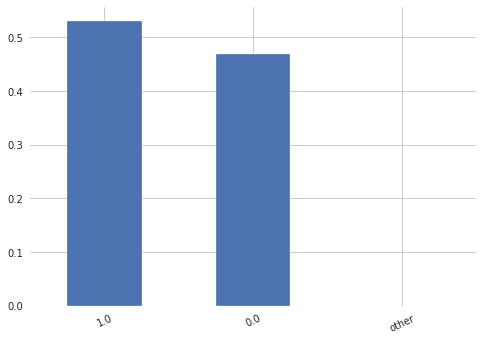

Flag to identify if the Customer is an everyday spender
****************************************************************************************************
0.0    14851
1.0     4744
Name: flag_cust_fee_paid_6m, dtype: int64


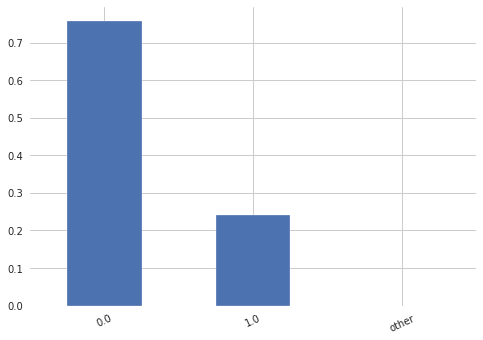

Flag if Customer has paid fee on any card in last 6 months
****************************************************************************************************
 -         590
 11         10
 1,373      10
 1,657       9
 1,550       9
          ... 
 8,879       1
 6,480       1
 6,237       1
 3,964       1
 3,255       1
Name: pre6m_cust_spend, Length: 9482, dtype: int64


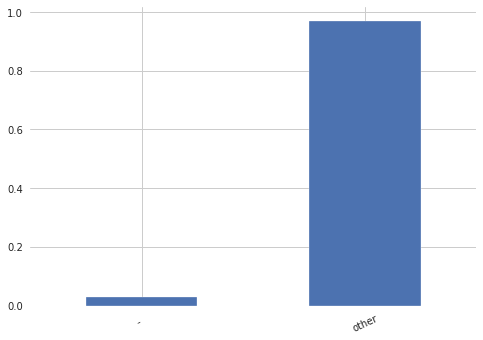

Total Spend  in last 6 months
****************************************************************************************************
0.0       590
2.0       142
4.0       117
6.0       109
12.0      108
         ... 
2000.0      1
1860.0      1
2100.0      1
1804.0      1
2164.0      1
Name: pre6m_cust_roc_cnt, Length: 975, dtype: int64


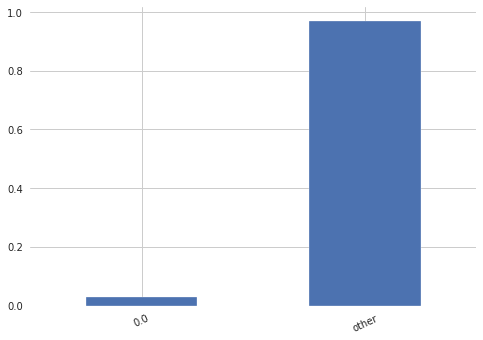

Total number of transactions in last 6 months
****************************************************************************************************
 -         1182
 11          34
 5           32
 21          29
 26          29
           ... 
 9,528        1
 3,296        1
 3,697        1
 2,673        1
 2,502        1
Name: pre6m_cust_non_disc_amt, Length: 4048, dtype: int64


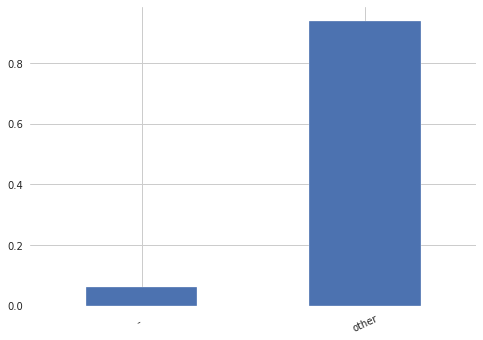

Total Non discretionary spend in last 6 months
****************************************************************************************************
0.0       1182
2.0        423
4.0        338
6.0        277
8.0        265
          ... 
1082.0       1
850.0        1
646.0        1
714.0        1
720.0        1
Name: pre6m_cust_non_disc_cnt, Length: 394, dtype: int64


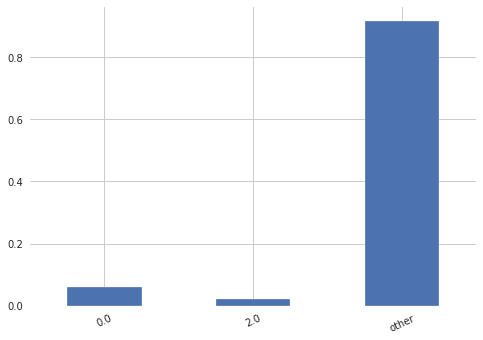

Total Non discretionary transactions in last 6 months
****************************************************************************************************
 -         693
 19         12
 391        12
 44         12
 718        11
          ... 
 3,854       1
 1,725       1
 8,672       1
 8,349       1
 9,061       1
Name: pre6m_cust_disc_amt, Length: 8208, dtype: int64


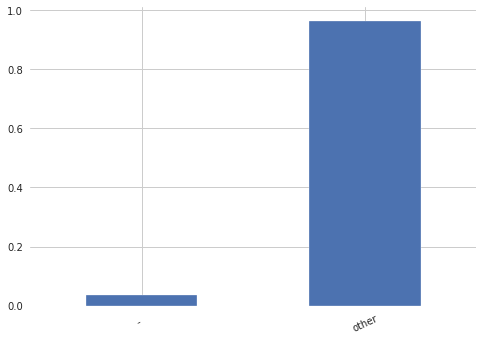

Total discretionary spend in last 6 months
****************************************************************************************************
0.0       692
2.0       198
6.0       185
4.0       172
10.0      150
         ... 
1410.0      1
1384.0      1
1610.0      1
1420.0      1
1550.0      1
Name: pre6m_cust_disc_cnt, Length: 791, dtype: int64


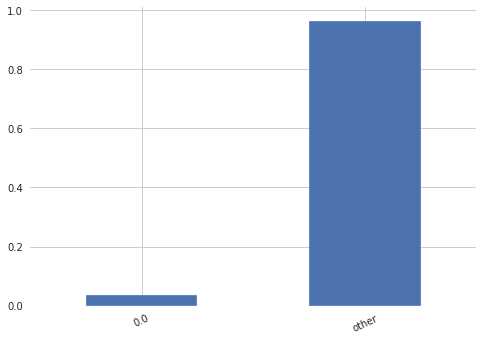

Total discretionary transactions in last 6 months
****************************************************************************************************
 -          2177
 5            67
 11           66
 3            63
 21           58
            ... 
 1,672         1
 2,325         1
 11,751        1
 3,053         1
 56,821        1
Name: pre6m_cust_outbound_amt, Length: 3520, dtype: int64


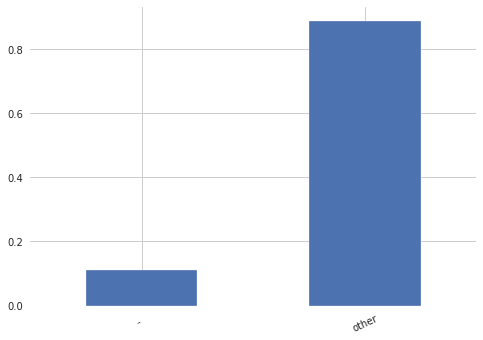

Total outbound spend in last 6 months
****************************************************************************************************
 -          1211
 8            21
 11           20
 19           19
 30           18
            ... 
 4,895         1
 7,602         1
 10,659        1
 2,425         1
 57,149        1
Name: pre6m_cust_online_amt, Length: 5970, dtype: int64


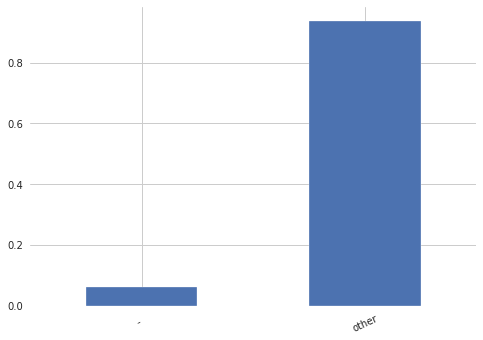

Total online spend in last 6 months
****************************************************************************************************
0.0        1207
4.0         520
8.0         383
12.0        368
16.0        359
           ... 
3116.0        1
1848.0        1
1236.0        1
2008.0        1
10236.0       1
Name: pre6m_cust_online_cnt, Length: 455, dtype: int64


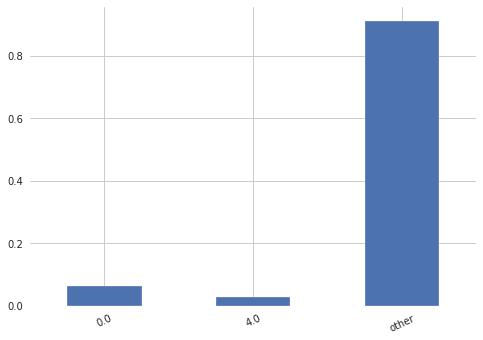

Total online transactions in last 6 months
****************************************************************************************************
 -          1921
 3            54
 4            45
 7            43
 2            43
            ... 
 3,424         1
 13,339        1
 5,489         1
 6,997         1
 3,255         1
Name: pre6m_cust_travel_amt, Length: 4876, dtype: int64


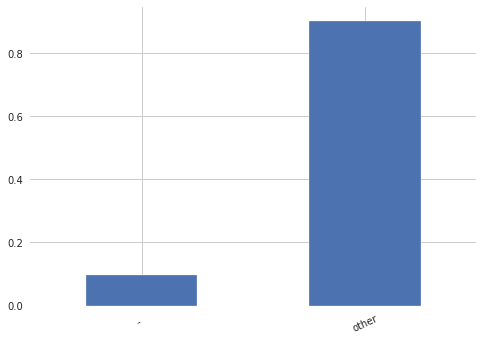

Total travel spend in last 6 months
****************************************************************************************************
0.0      1921
2.0       866
4.0       737
6.0       627
8.0       578
         ... 
710.0       1
988.0       1
702.0       1
738.0       1
584.0       1
Name: pre6m_cust_travel_cnt, Length: 369, dtype: int64


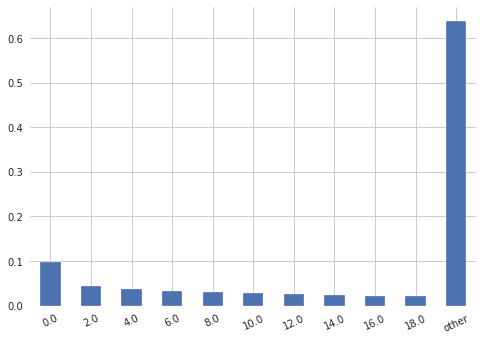

Total travel transactions in last 6 months
****************************************************************************************************
 -         834
 11         26
 5          20
 9          19
 28         17
          ... 
 2,747       1
 3,899       1
 7,602       1
 7,828       1
 3,255       1
Name: pre6m_cust_retail_amt, Length: 5627, dtype: int64


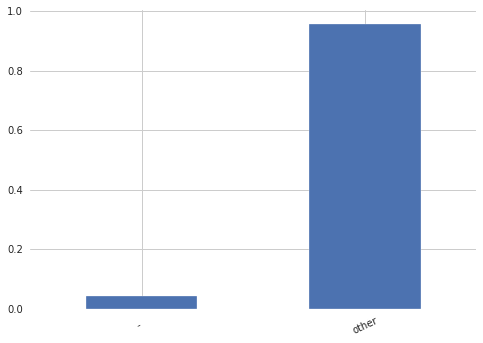

Total retail spend in last 6 months
****************************************************************************************************
0.0       836
2.0       267
4.0       224
6.0       221
8.0       189
         ... 
776.0       1
910.0       1
760.0       1
1186.0      1
1108.0      1
Name: pre6m_cust_retail_cnt, Length: 517, dtype: int64


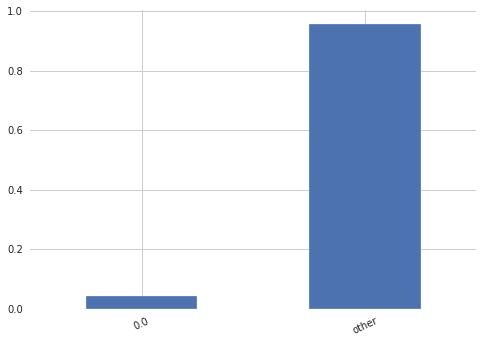

Total retail transactions in last 6 months
****************************************************************************************************
0.0     4524
4.0     3384
9.0     2500
5.0     2306
6.0     1367
7.0     1312
3.0     1197
8.0     1003
15.0     947
13.0     343
11.0     278
21.0     255
18.0      63
27.0      53
12.0      40
33.0      11
23.0       7
19.0       4
28.0       1
Name: pre6m_cust_myca_active, dtype: int64


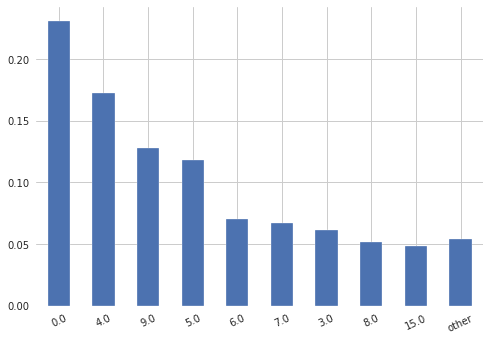

Number of times the Customer logged into his online XZVEE account in last 6 months
****************************************************************************************************
0.0       4524
4.0       2130
5.0       1489
3.0       1197
6.0        906
          ... 
657.0        1
606.0        1
1315.0       1
391.0        1
341.0        1
Name: pre6m_cust_mob_logins, Length: 538, dtype: int64


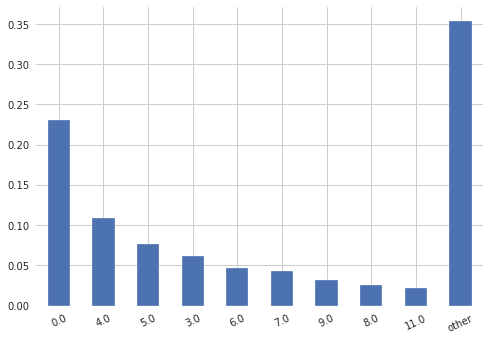

Number of times the Customer logged into his online XZVEE account in last 6 months through mobile
****************************************************************************************************
 (0)       577
 (1)       402
 1         347
 2         344
 0         261
          ... 
 1,458       1
 998         1
 355         1
 735         1
 481         1
Name: pre6m_total_mc_trs, Length: 985, dtype: int64


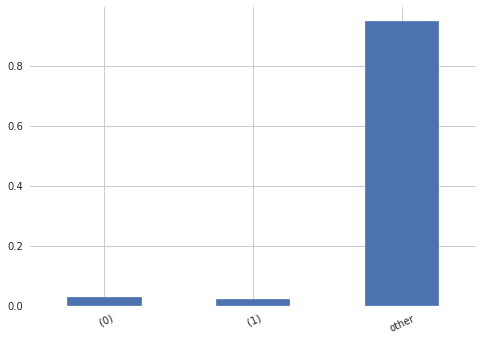

Total profit made by XZVEE on the customer in last 6 months
****************************************************************************************************
MGM                           7470
Unreferred                    4451
Partner                       1551
Affiliates                    1532
In House                      1325
Paid Search                    703
Direct                         629
Media                          352
Search                         297
Interactive                    145
Non-PDB (Personalized)          45
Email                           40
Partnerships - Other            38
Outsourced                      35
PDB (Personalized)              21
Natural Referral                21
E-Mails                         16
Partnerships - In Store          6
Personalization                  5
E-mails                          4
Outbound                         2
Unaddressed                      2
DM                               1
Natural Search                   1

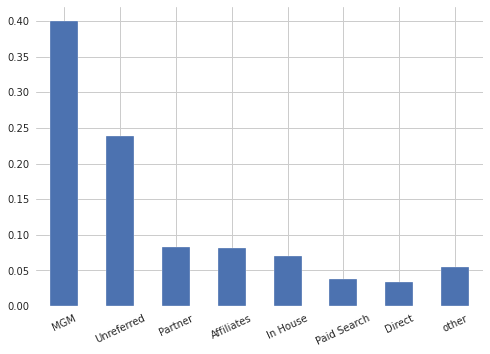

Channel of acquisition of first the firt card of the customer
****************************************************************************************************
external     13520
spillover     3715
others        1488
Name: acq_type_grp, dtype: int64


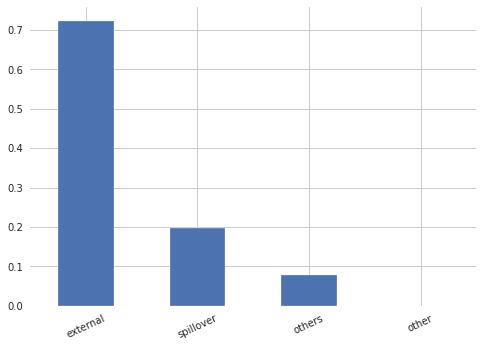

Customer type: Existing Customer or prospect
****************************************************************************************************
no_fee         8592
full_fee       7267
reduced_fee    3708
unknown          28
Name: fee_type_grp, dtype: int64


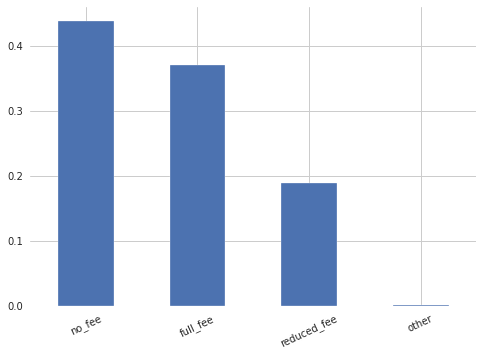

Fe type of the first card of the customer
****************************************************************************************************
3.0      1253
1.0      1113
2.0       914
5.0       712
11.0      676
         ... 
371.0       1
247.0       1
197.0       1
239.0       1
348.0       1
Name: Cust_tenure, Length: 283, dtype: int64


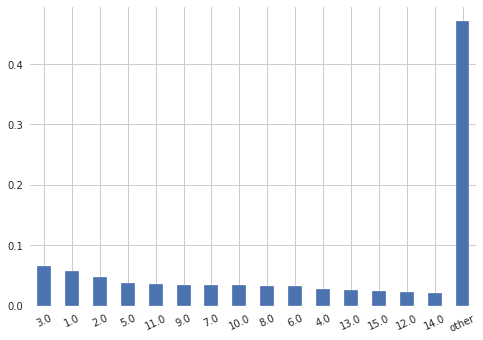

Total Tenure of the cutomer with XZVEE in months
****************************************************************************************************
1.0    18062
0.0     1297
Name: pre6m_spend_active_ind, dtype: int64


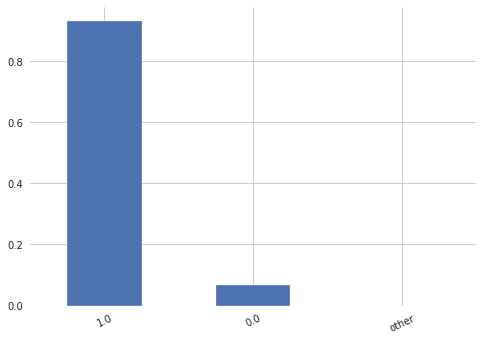

Flag to indicate if the customer has spent on the cards in last 6 months
****************************************************************************************************
0.0    17901
1.0     1458
Name: highly_utilized_ind, dtype: int64


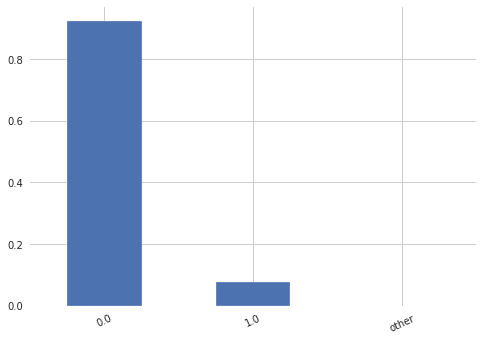

CM has spent >80% of the card limit in past 6 months om any of his cards
****************************************************************************************************
0.0    18938
1.0      421
Name: min_pay_ind, dtype: int64


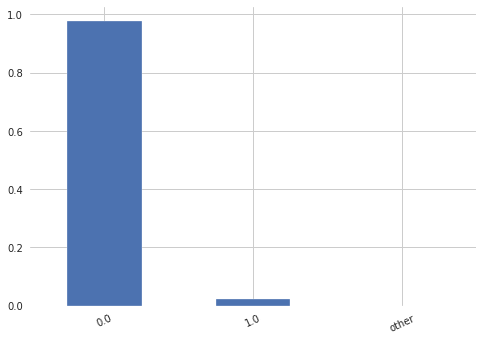

Flag to indicate if the customer has paid the minimum amount on the card ever in last 6 billing cycles
****************************************************************************************************
1.0    11435
0.0     7924
Name: paid_in_full_ind, dtype: int64


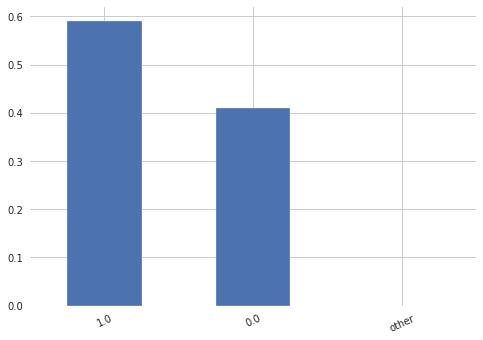

Flag to indicate if the customer has paid the total amount on any of the cards ever in last 6 billing cycles
****************************************************************************************************
 -           1784
 20,000       700
 40,000       582
 6,667        346
 4,000        341
             ... 
 14,067         1
 141,000        1
 19,533         1
 119,067        1
 88,533         1
Name: sum_total_line_amt, Length: 1442, dtype: int64


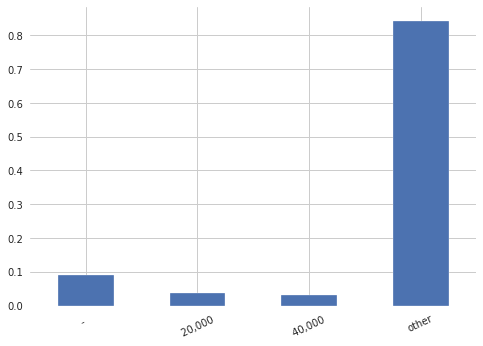

Total credit limits of all cards with the customer
****************************************************************************************************
0.0    10120
1.0     9239
Name: direct_debit_ind, dtype: int64


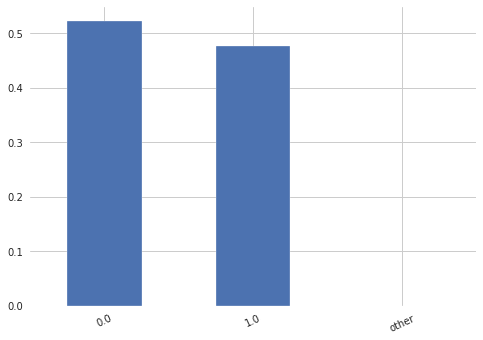

Flag to indicate if the customer has set up auto payment
****************************************************************************************************
0.0      13737
1.0       3412
2.0       1115
3.0        473
4.0        214
5.0        136
6.0         81
7.0         57
8.0         29
9.0         19
10.0        19
11.0        10
15.0         7
13.0         7
12.0         4
16.0         4
20.0         4
14.0         4
17.0         4
18.0         3
30.0         2
26.0         2
22.0         2
33.0         2
32.0         1
52.0         1
64.0         1
21.0         1
235.0        1
50.0         1
37.0         1
28.0         1
29.0         1
71.0         1
19.0         1
38.0         1
Name: referrals, dtype: int64


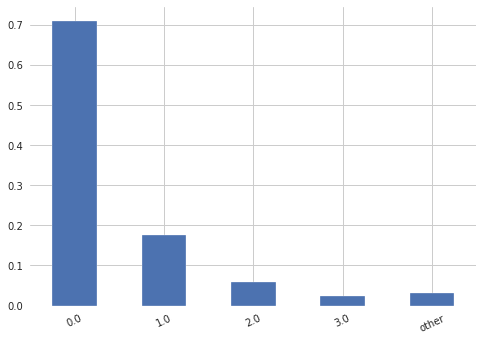

Number of previous successful referrals made by customer in previous 5 years
****************************************************************************************************
0.0     17381
1.0      1182
2.0       356
3.0       165
4.0        91
5.0        54
6.0        39
7.0        34
9.0        12
8.0         9
12.0        7
13.0        6
11.0        5
10.0        4
22.0        2
15.0        2
14.0        2
23.0        1
17.0        1
19.0        1
35.0        1
72.0        1
20.0        1
26.0        1
18.0        1
Name: spillover, dtype: int64


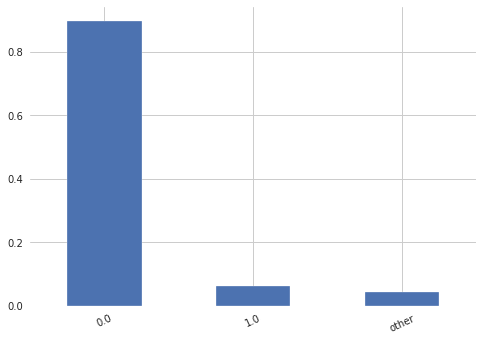

Number of spillovers from the successful referrals
****************************************************************************************************
0.0     19023
1.0       203
2.0        83
3.0        29
4.0        11
5.0         5
7.0         2
11.0        1
9.0         1
6.0         1
Name: self_accts, dtype: int64


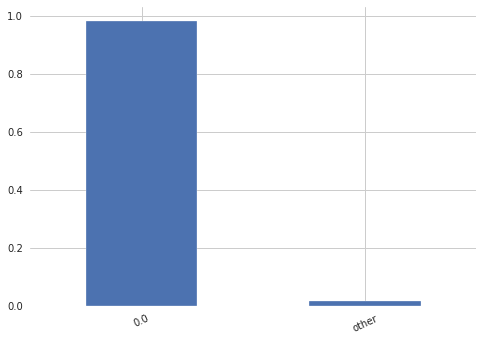

No of cards when the customer self referred
****************************************************************************************************
0.0    19189
1.0      170
Name: Customer Low Quality indicator, dtype: int64


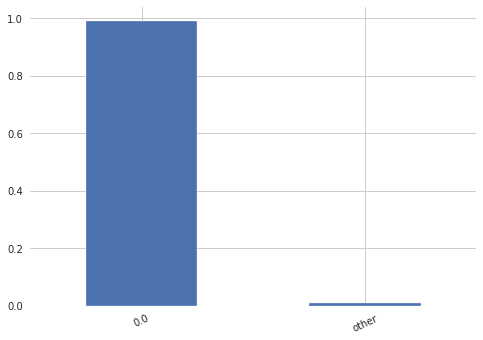

Flag to identify if the customer is a low quality acquisition
****************************************************************************************************
0.000    13158
0.001     2381
0.004      694
0.005      394
0.003      279
         ...  
0.469        1
0.158        1
0.148        1
0.369        1
0.413        1
Name: cdss_most_rcnt_prob, Length: 297, dtype: int64


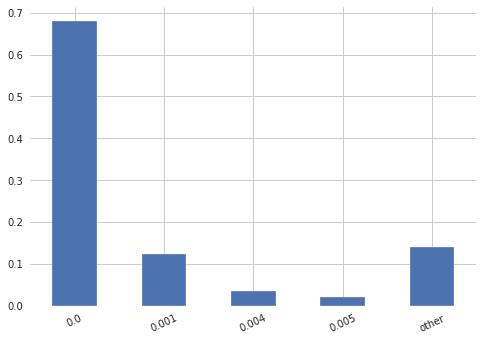

Internal XZVEE risk score generated for the customer
****************************************************************************************************
 -         1853
 21          26
 42          26
 1,250       24
 83          23
           ... 
 5,076        1
 4,729        1
 4,776        1
 3,273        1
 3,255        1
Name: cust_max_credit_12m_amt, Length: 4807, dtype: int64


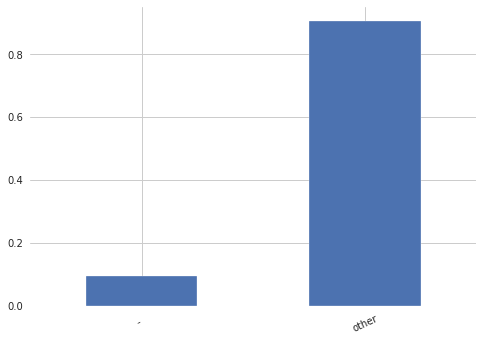

Maximum amount of single transaction made by customer in past 12 months
****************************************************************************************************
 -          2002
 833          53
 1,250        38
 417          38
 625          38
            ... 
 5,355         1
 2,879         1
 8,239         1
 20,398        1
 3,188         1
Name: cust_max_remit_12m_amt, Length: 4597, dtype: int64


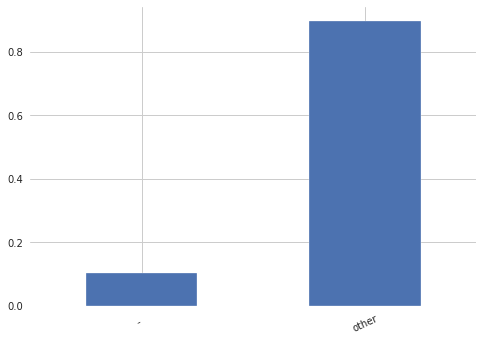

Maximum amount of single transaction payment made by customer in past 12 months
****************************************************************************************************
1350.0    1143
1376.0    1091
1300.0     720
0.0        482
1353.0     446
          ... 
678.0        1
679.0        1
1249.0       1
735.0        1
1389.0       1
Name: cbr_3_score, Length: 608, dtype: int64


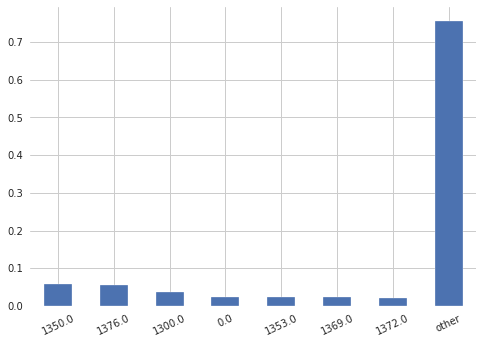

External Bureau score of the customer
****************************************************************************************************
0.0    16330
1.0     2964
2.0       56
Name: cnsumr_chrg_actv_cust_cnt, dtype: int64


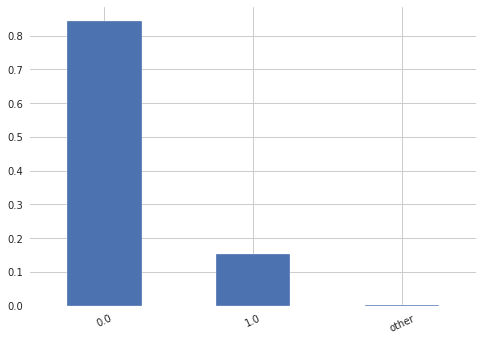

Number of active charge card account of the customer
****************************************************************************************************
 -         15448
 0            45
 5            43
 1            29
 3            21
           ...  
 699           1
 3,007         1
 1,325         1
 2,731         1
 1,602         1
Name: cnsumr_chrg_avg_credit_12m_amt, Length: 1441, dtype: int64


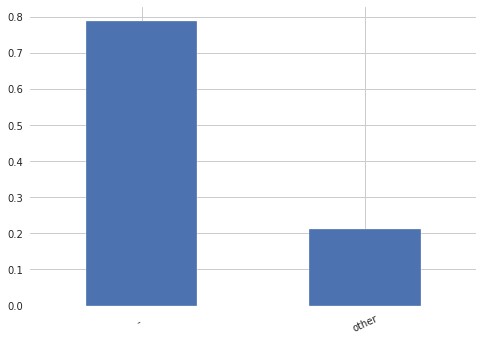

Average monthly spend on Charge cards 
****************************************************************************************************
1.0    15166
2.0     2205
0.0     1693
3.0      260
4.0       25
5.0        1
Name: cnsumr_lend_actv_cust_cnt, dtype: int64


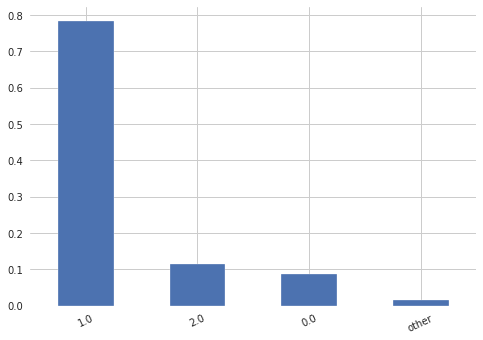

Number of active lending card account of the customer
****************************************************************************************************
0.000000    3555
0.025000       6
0.001400       5
0.000650       4
0.000160       4
            ... 
0.011936       1
0.036531       1
0.140412       1
0.104086       1
0.034040       1
Name: cnsumr_lend_tot_util_ratio, Length: 15236, dtype: int64


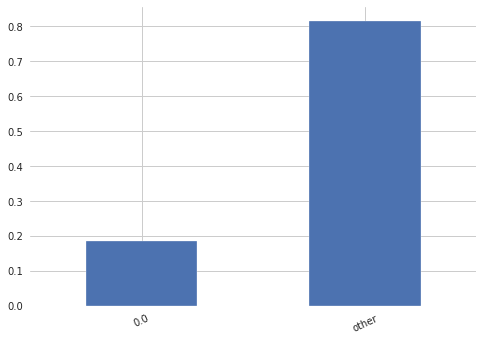

Total credit limit used off the assigned lending limit
****************************************************************************************************
0.0000    16223
0.0100      247
0.0224       54
0.0223       29
0.0248       19
          ...  
0.0651        1
0.0515        1
0.2936        1
0.2431        1
0.1992        1
Name: sow_revol_avg_paydown_pct, Length: 1567, dtype: int64


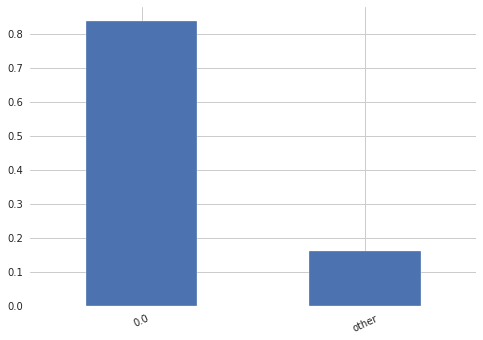

Size of Wallet: Total amount paid over revolving balance on external cards
****************************************************************************************************
 -         10557
 10           15
 208          14
 83           14
 500          13
           ...  
 3,074         1
 3,695         1
 1,526         1
 1,846         1
 6,201         1
Name: sow_tot_annual_ext_pmt_amt, Length: 5680, dtype: int64


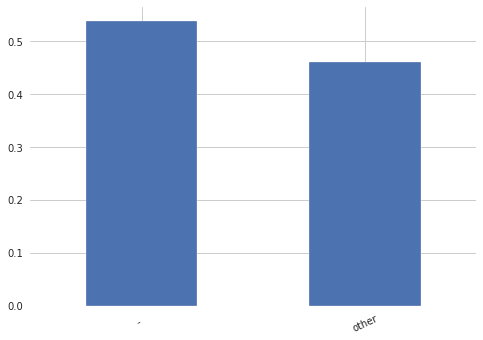

Size of Wallet: Average amount paid on external cards annually
****************************************************************************************************
 -          16492
 0              9
 250            8
 208            7
 1,125          6
            ...  
 1,846          1
 1,501          1
 543            1
 3,071          1
 11,909         1
Name: sow_tot_revol_bal_amt, Length: 2394, dtype: int64


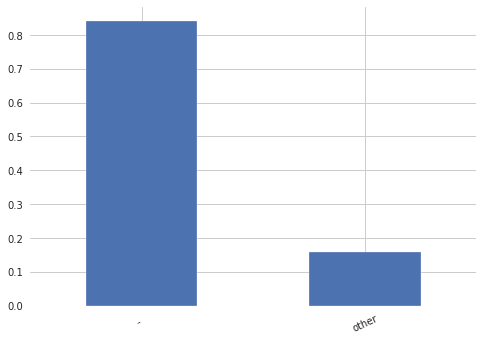

Size of Wallet: Total revolve balance on external cards
****************************************************************************************************
0.0     16223
2.0      1909
3.0       686
4.0       293
5.0       141
6.0        61
7.0        24
8.0        10
10.0        2
9.0         1
Name: sow_tot_revol_cnt, dtype: int64


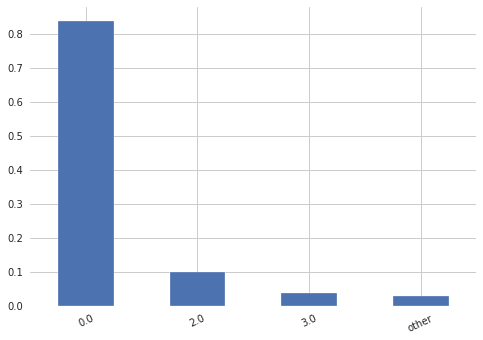

Size of Wallet: Total external lending cards count
****************************************************************************************************
 -         13909
 3            75
 1            71
 4            50
 10           42
           ...  
 2,348         1
 1,394         1
 2,902         1
 829           1
 5,709         1
Name: sow_tot_trans_bal_amt, Length: 1457, dtype: int64


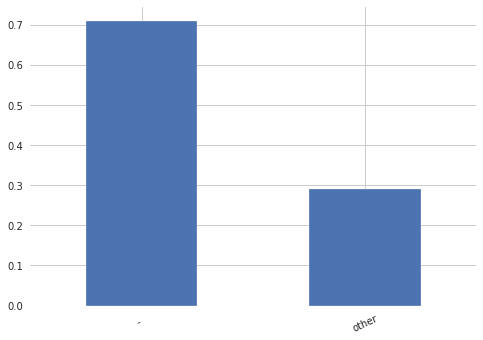

Size of Wallet: Total balance amount on external cards
****************************************************************************************************
0.0     12886
2.0      4783
3.0      1249
4.0       305
5.0        87
6.0        29
7.0         5
8.0         3
9.0         1
13.0        1
12.0        1
Name: sow_tot_trans_cnt, dtype: int64


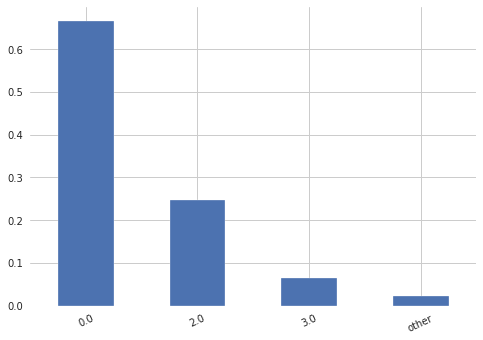

Size of Wallet: Total external charge cards count
****************************************************************************************************


In [ ]:
for col in features:
    print(df_train[col].value_counts())
    prob = df_train[col].value_counts(normalize=True)
    threshold = 0.02
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['other'] = tail_prob
    prob.plot(kind='bar')
    plt.xticks(rotation=25)
    plt.show()
    print(description[col])
    print('*'*100)

## Data Preprocessing

##### Duplicate rows

In [ ]:
print("Total duplicate rows :",df_train.duplicated().sum())

Total duplicate rows : 3


-> Not a significant value

#### Missing values Treatment

There are two types of missing values :
1. NULL values
2. -- values

In [ ]:
obs = df_train.isnull().sum().sort_values(ascending = False)
percent = round(df_train.isnull().sum().sort_values(ascending = False)/len(df_train)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Missing Observations', 'Percent(%)'])

,Number of Missing Observations,Percent(%)
acq_sub_chn,906,4.62
acq_type_grp,876,4.47
sow_tot_trans_cnt,249,1.27
sow_tot_revol_cnt,249,1.27
sow_revol_avg_paydown_pct,249,1.27
cnsumr_lend_tot_util_ratio,249,1.27
cnsumr_lend_actv_cust_cnt,249,1.27
cnsumr_chrg_actv_cust_cnt,249,1.27
cbr_3_score,249,1.27
cdss_most_rcnt_prob,249,1.27


In [ ]:
# drop rows where cust_id is null
df_trainc = df_train[:-4] 
obs = df_trainc.isnull().sum().sort_values(ascending = False)
percent = round(df_trainc.isnull().sum().sort_values(ascending = False)/len(df_trainc)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Missing Observations', 'Percent(%)'])

,Number of Missing Observations,Percent(%)
acq_sub_chn,902,4.60
acq_type_grp,872,4.45
sow_tot_trans_cnt,245,1.25
sow_tot_revol_cnt,245,1.25
sow_revol_avg_paydown_pct,245,1.25
cnsumr_lend_tot_util_ratio,245,1.25
cnsumr_lend_actv_cust_cnt,245,1.25
cnsumr_chrg_actv_cust_cnt,245,1.25
cbr_3_score,245,1.25
cdss_most_rcnt_prob,245,1.25


In [ ]:
df_trainc.dtypes

cust_id                           float64
profitable_flag                   float64
count_accts                       float64
cm_age                            float64
flag_top_ed_spender               float64
flag_cust_fee_paid_6m             float64
pre6m_cust_spend                   object
pre6m_cust_roc_cnt                float64
pre6m_cust_non_disc_amt            object
pre6m_cust_non_disc_cnt           float64
pre6m_cust_disc_amt                object
pre6m_cust_disc_cnt               float64
pre6m_cust_outbound_amt            object
pre6m_cust_online_amt              object
pre6m_cust_online_cnt             float64
pre6m_cust_travel_amt              object
pre6m_cust_travel_cnt             float64
pre6m_cust_retail_amt              object
pre6m_cust_retail_cnt             float64
pre6m_cust_myca_active            float64
pre6m_cust_mob_logins             float64
pre6m_total_mc_trs                 object
acq_sub_chn                        object
acq_type_grp                      

In [ ]:
# columns having object data type
obj_col = ['pre6m_cust_spend', 'pre6m_cust_non_disc_amt', 'pre6m_cust_disc_amt', 'pre6m_cust_outbound_amt', 'pre6m_cust_online_amt', 'pre6m_cust_travel_amt', 'pre6m_cust_retail_amt', 'pre6m_total_mc_trs', 'acq_sub_chn','acq_type_grp','fee_type_grp', 'sum_total_line_amt', 'cust_max_credit_12m_amt', 'cust_max_remit_12m_amt', 'cnsumr_chrg_avg_credit_12m_amt', 'sow_tot_annual_ext_pmt_amt', 'sow_tot_revol_bal_amt', 'sow_tot_trans_bal_amt']

In [ ]:
# remove brackets from values of 'pre6m_total_mc_trs'
ocol = ['pre6m_total_mc_trs']
l  = []  
for i in df_trainc[ocol[0]]:
    i = list(i)
    if(i.count('(')!=0):
        l.append(int(("".join(i[2:-1])).replace(',', '')))
    else:
        l.append(int(("".join(i[1:-1])).replace(',', '')))
df_trainc[ocol[0]] = l

In [ ]:
# remove brackets from values of 'pre6m_total_mc_trs'
ocol = ['pre6m_total_mc_trs']
l  = []  
for i in test_df[ocol[0]]:
    i = list(i)
    if(i.count('(')!=0):
        l.append(int(("".join(i[2:-1])).replace(',', '')))
    else:
        l.append(int(("".join(i[1:-1])).replace(',', '')))
test_df[ocol[0]] = l

In [ ]:
f =(lambda x: (str(x).replace(',', '')))
c = ['acq_sub_chn',	'acq_type_grp','fee_type_grp']
for col in obj_col:
    if(col not in c):
        df_trainc[col] = df_trainc[col].apply(f)
for col in obj_col:
    if(col not in c):
        df_trainc[col] = pd.to_numeric(df_trainc[col], errors='coerce')

In [ ]:
#for test data
f =(lambda x: (str(x).replace(',', '')))
c = ['acq_sub_chn',	'acq_type_grp','fee_type_grp']
for col in obj_col:
    if(col not in c):
        test_df[col] = test_df[col].apply(f)
for col in obj_col:
    if(col not in c):
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

In [ ]:
df_trainc.head()

,cust_id,profitable_flag,count_accts,cm_age,flag_top_ed_spender,flag_cust_fee_paid_6m,pre6m_cust_spend,pre6m_cust_roc_cnt,pre6m_cust_non_disc_amt,pre6m_cust_non_disc_cnt,pre6m_cust_disc_amt,pre6m_cust_disc_cnt,pre6m_cust_outbound_amt,pre6m_cust_online_amt,pre6m_cust_online_cnt,pre6m_cust_travel_amt,pre6m_cust_travel_cnt,pre6m_cust_retail_amt,pre6m_cust_retail_cnt,pre6m_cust_myca_active,pre6m_cust_mob_logins,pre6m_total_mc_trs,acq_sub_chn,acq_type_grp,fee_type_grp,Cust_tenure,pre6m_spend_active_ind,highly_utilized_ind,min_pay_ind,paid_in_full_ind,sum_total_line_amt,direct_debit_ind,referrals,spillover,self_accts,Customer Low Quality indicator,cdss_most_rcnt_prob,cust_max_credit_12m_amt,cust_max_remit_12m_amt,cbr_3_score,cnsumr_chrg_actv_cust_cnt,cnsumr_chrg_avg_credit_12m_amt,cnsumr_lend_actv_cust_cnt,cnsumr_lend_tot_util_ratio,sow_revol_avg_paydown_pct,sow_tot_annual_ext_pmt_amt,sow_tot_revol_bal_amt,sow_tot_revol_cnt,sow_tot_trans_bal_amt,sow_tot_trans_cnt
0,550391.0,0.0,1.0,74.0,1.0,0.0,1518.0,122.0,811.0,96.0,707.0,26.0,NaN,606.0,36.0,28.0,2.0,814.0,98.0,9.0,203.0,2,Unreferred,external,no_fee,63.0,1.0,0.0,0.0,1.0,80000.0,1.0,1.0,0.0,0.0,0.0,0.000,482.0,418.0,1376.0,0.0,NaN,1.0,0.034044,0.0000,991.0,NaN,0.0,NaN,3.0
1,550392.0,0.0,1.0,64.0,0.0,0.0,4807.0,354.0,1052.0,82.0,3756.0,272.0,673.0,3164.0,456.0,2291.0,44.0,1265.0,116.0,0.0,0.0,15,In House,others,no_fee,203.0,1.0,0.0,0.0,1.0,140000.0,1.0,1.0,1.0,0.0,0.0,0.000,2165.0,2165.0,1300.0,0.0,7.0,1.0,0.044086,0.0877,2.0,24.0,2.0,NaN,0.0
2,550393.0,0.0,1.0,75.0,1.0,0.0,2361.0,204.0,1351.0,118.0,1010.0,86.0,237.0,693.0,152.0,NaN,0.0,1623.0,166.0,9.0,18.0,20,NaN,NaN,full_fee,201.0,1.0,0.0,0.0,1.0,32800.0,0.0,0.0,0.0,0.0,0.0,0.000,703.0,687.0,1376.0,0.0,NaN,1.0,0.039613,0.0000,4828.0,NaN,0.0,387.0,3.0
3,550394.0,0.0,2.0,73.0,0.0,1.0,5452.0,142.0,1195.0,50.0,4257.0,92.0,803.0,1618.0,64.0,2760.0,54.0,1605.0,54.0,9.0,23.0,30,NaN,NaN,full_fee,286.0,1.0,0.0,0.0,1.0,100000.0,1.0,0.0,0.0,0.0,0.0,0.000,1225.0,1225.0,1372.0,1.0,493.0,1.0,0.001200,0.0000,4598.0,NaN,0.0,295.0,4.0
4,550395.0,0.0,2.0,68.0,0.0,0.0,170.0,34.0,88.0,20.0,82.0,14.0,10.0,10.0,4.0,NaN,0.0,66.0,18.0,0.0,0.0,9,Affiliates,spillover,no_fee,123.0,1.0,0.0,0.0,1.0,20800.0,1.0,0.0,0.0,0.0,0.0,0.001,51.0,35.0,1338.0,0.0,NaN,2.0,0.003378,0.0168,2176.0,2606.0,5.0,143.0,13.0


In [ ]:
df_train.head()

,cust_id,profitable_flag,count_accts,cm_age,flag_top_ed_spender,flag_cust_fee_paid_6m,pre6m_cust_spend,pre6m_cust_roc_cnt,pre6m_cust_non_disc_amt,pre6m_cust_non_disc_cnt,pre6m_cust_disc_amt,pre6m_cust_disc_cnt,pre6m_cust_outbound_amt,pre6m_cust_online_amt,pre6m_cust_online_cnt,pre6m_cust_travel_amt,pre6m_cust_travel_cnt,pre6m_cust_retail_amt,pre6m_cust_retail_cnt,pre6m_cust_myca_active,pre6m_cust_mob_logins,pre6m_total_mc_trs,acq_sub_chn,acq_type_grp,fee_type_grp,Cust_tenure,pre6m_spend_active_ind,highly_utilized_ind,min_pay_ind,paid_in_full_ind,sum_total_line_amt,direct_debit_ind,referrals,spillover,self_accts,Customer Low Quality indicator,cdss_most_rcnt_prob,cust_max_credit_12m_amt,cust_max_remit_12m_amt,cbr_3_score,cnsumr_chrg_actv_cust_cnt,cnsumr_chrg_avg_credit_12m_amt,cnsumr_lend_actv_cust_cnt,cnsumr_lend_tot_util_ratio,sow_revol_avg_paydown_pct,sow_tot_annual_ext_pmt_amt,sow_tot_revol_bal_amt,sow_tot_revol_cnt,sow_tot_trans_bal_amt,sow_tot_trans_cnt
0,550391.0,0.0,1.0,74.0,1.0,0.0,"1,518",122.0,811,96.0,707,26.0,-,606,36.0,28,2.0,814,98.0,9.0,203.0,(2),Unreferred,external,no_fee,63.0,1.0,0.0,0.0,1.0,"80,000",1.0,1.0,0.0,0.0,0.0,0.000,482,418,1376.0,0.0,-,1.0,0.034044,0.0000,991,-,0.0,-,3.0
1,550392.0,0.0,1.0,64.0,0.0,0.0,"4,807",354.0,"1,052",82.0,"3,756",272.0,673,"3,164",456.0,"2,291",44.0,"1,265",116.0,0.0,0.0,15,In House,others,no_fee,203.0,1.0,0.0,0.0,1.0,"140,000",1.0,1.0,1.0,0.0,0.0,0.000,"2,165","2,165",1300.0,0.0,7,1.0,0.044086,0.0877,2,24,2.0,-,0.0
2,550393.0,0.0,1.0,75.0,1.0,0.0,"2,361",204.0,"1,351",118.0,"1,010",86.0,237,693,152.0,-,0.0,"1,623",166.0,9.0,18.0,(20),NaN,NaN,full_fee,201.0,1.0,0.0,0.0,1.0,"32,800",0.0,0.0,0.0,0.0,0.0,0.000,703,687,1376.0,0.0,-,1.0,0.039613,0.0000,"4,828",-,0.0,387,3.0
3,550394.0,0.0,2.0,73.0,0.0,1.0,"5,452",142.0,"1,195",50.0,"4,257",92.0,803,"1,618",64.0,"2,760",54.0,"1,605",54.0,9.0,23.0,30,NaN,NaN,full_fee,286.0,1.0,0.0,0.0,1.0,"100,000",1.0,0.0,0.0,0.0,0.0,0.000,"1,225","1,225",1372.0,1.0,493,1.0,0.001200,0.0000,"4,598",-,0.0,295,4.0
4,550395.0,0.0,2.0,68.0,0.0,0.0,170,34.0,88,20.0,82,14.0,10,10,4.0,-,0.0,66,18.0,0.0,0.0,(9),Affiliates,spillover,no_fee,123.0,1.0,0.0,0.0,1.0,"20,800",1.0,0.0,0.0,0.0,0.0,0.001,51,35,1338.0,0.0,-,2.0,0.003378,0.0168,"2,176","2,606",5.0,143,13.0


In [ ]:
df_trainc.dtypes

cust_id                           float64
profitable_flag                   float64
count_accts                       float64
cm_age                            float64
flag_top_ed_spender               float64
flag_cust_fee_paid_6m             float64
pre6m_cust_spend                  float64
pre6m_cust_roc_cnt                float64
pre6m_cust_non_disc_amt           float64
pre6m_cust_non_disc_cnt           float64
pre6m_cust_disc_amt               float64
pre6m_cust_disc_cnt               float64
pre6m_cust_outbound_amt           float64
pre6m_cust_online_amt             float64
pre6m_cust_online_cnt             float64
pre6m_cust_travel_amt             float64
pre6m_cust_travel_cnt             float64
pre6m_cust_retail_amt             float64
pre6m_cust_retail_cnt             float64
pre6m_cust_myca_active            float64
pre6m_cust_mob_logins             float64
pre6m_total_mc_trs                  int64
acq_sub_chn                        object
acq_type_grp                      

In [ ]:
test_df.dtypes

count_accts                         int64
cm_age                              int64
flag_top_ed_spender               float64
flag_cust_fee_paid_6m               int64
pre6m_cust_spend                  float64
pre6m_cust_roc_cnt                  int64
pre6m_cust_non_disc_amt           float64
pre6m_cust_non_disc_cnt             int64
pre6m_cust_disc_amt               float64
pre6m_cust_disc_cnt                 int64
pre6m_cust_outbound_amt           float64
pre6m_cust_online_amt             float64
pre6m_cust_online_cnt               int64
pre6m_cust_travel_amt             float64
pre6m_cust_travel_cnt               int64
pre6m_cust_retail_amt             float64
pre6m_cust_retail_cnt               int64
pre6m_cust_myca_active              int64
pre6m_cust_mob_logins               int64
pre6m_total_mc_trs                  int64
acq_sub_chn                        object
acq_type_grp                       object
fee_type_grp                       object
Cust_tenure                       

In [ ]:
# After replacing dash value by nan lets see the total number of missing values
obs = df_trainc.isnull().sum().sort_values(ascending = False)
percent = round(df_trainc.isnull().sum().sort_values(ascending = False)/len(df_trainc)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Missing Observations', 'Percent(%)'])

,Number of Missing Observations,Percent(%)
sow_tot_revol_bal_amt,16498,84.19
cnsumr_chrg_avg_credit_12m_amt,15448,78.84
sow_tot_trans_bal_amt,14089,71.90
sow_tot_annual_ext_pmt_amt,10557,53.88
pre6m_cust_outbound_amt,2246,11.46
cust_max_remit_12m_amt,2002,10.22
pre6m_cust_travel_amt,1974,10.07
cust_max_credit_12m_amt,1853,9.46
sum_total_line_amt,1784,9.10
pre6m_cust_online_amt,1249,6.37


In [ ]:
# After replacing dash value by nan lets see the total number of missing values
obs = test_df.isnull().sum().sort_values(ascending = False)
percent = round(df_trainc.isnull().sum().sort_values(ascending = False)/len(test_df)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Missing Observations', 'Percent(%)'])

,Number of Missing Observations,Percent(%)
sow_tot_revol_bal_amt,4186.0,329.96
cnsumr_chrg_avg_credit_12m_amt,3975.0,308.96
sow_tot_trans_bal_amt,3643.0,281.78
sow_tot_annual_ext_pmt_amt,2752.0,211.14
pre6m_cust_outbound_amt,594.0,44.92
pre6m_cust_travel_amt,530.0,39.48
cust_max_remit_12m_amt,511.0,40.04
cust_max_credit_12m_amt,479.0,37.06
sum_total_line_amt,464.0,35.68
pre6m_cust_non_disc_amt,357.0,23.84


In [ ]:
# drop the columns having missing values more than 50%
missing_cols = ['sow_tot_revol_bal_amt', 'cnsumr_chrg_avg_credit_12m_amt', 'sow_tot_trans_bal_amt', 'sow_tot_annual_ext_pmt_amt']
df_trainc.drop(columns=missing_cols, inplace=True)
test_df.drop(columns=  missing_cols, inplace =True)

In [ ]:
test_df.drop(columns=  missing_cols, inplace =True)

KeyError: ignored

In [ ]:
obs = df_trainc.isnull().sum().sort_values(ascending = False)
percent = round(df_trainc.isnull().sum().sort_values(ascending = False)/len(df_trainc)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Missing Observations', 'Percent(%)'])

,Number of Missing Observations,Percent(%)
pre6m_cust_outbound_amt,2246,11.46
cust_max_remit_12m_amt,2002,10.22
pre6m_cust_travel_amt,1974,10.07
cust_max_credit_12m_amt,1853,9.46
sum_total_line_amt,1784,9.10
pre6m_cust_online_amt,1249,6.37
pre6m_cust_non_disc_amt,1192,6.08
acq_sub_chn,902,4.60
acq_type_grp,872,4.45
pre6m_cust_retail_amt,854,4.36


#### Encoding

In [ ]:
# we have 3 categorical columns
cat_col = ['acq_sub_chn', 'acq_type_grp', 'fee_type_grp']
df_trainc['fee_type_grp']  =df_trainc['fee_type_grp'].map({'no_fee':0, 'full_fee':2, 'reduced_fee':1, 'unknown':-1})
train_en = df_trainc.copy()
train_en[cat_col[0]] = train_en[cat_col[0]].map({'MGM':0, 'Unreferred':1, 'Affiliates':2, 'In House':3,'Paid Search':4, 'Direct':5, 'Media':6, 'Search':-2,'Interactive':-2, 'Non-PDB (Personalized)':-2, 'Email':-2, 'Partnerships - Other':-2,'Outsourced':-2, 'Natural Referral':-2, 'PDB (Personalized)':-2, 'E-Mails':-2, 'Outbound':-2, 'Unaddressed':-2, 'Natural Search':-2, 'DM':-2, 'Proprietary - Direct Sales':-2})
train_en['acq_type_grp'] = train_en['acq_type_grp'].map({'external':1, 'spillover':0, 'others':-1})

In [ ]:
# we have 3 categorical columns for test data encoding
cat_col = ['acq_sub_chn', 'acq_type_grp', 'fee_type_grp']
test_df['fee_type_grp']  =test_df['fee_type_grp'].map({'no_fee':0, 'full_fee':2, 'reduced_fee':1, 'unknown':-1})
test_df[cat_col[0]] = test_df[cat_col[0]].map({'MGM':0, 'Unreferred':1, 'Affiliates':2, 'In House':3,'Paid Search':4, 'Direct':5, 'Media':6, 'Search':-2,'Interactive':-2, 'Non-PDB (Personalized)':-2, 'Email':-2, 'Partnerships - Other':-2,'Outsourced':-2, 'Natural Referral':-2, 'PDB (Personalized)':-2, 'E-Mails':-2, 'Outbound':-2, 'Unaddressed':-2, 'Natural Search':-2, 'DM':-2, 'Proprietary - Direct Sales':-2})
test_df['acq_type_grp'] = test_df['acq_type_grp'].map({'external':1, 'spillover':0, 'others':-1})

In [ ]:
for col in train_en.columns:
    train_en[col] = train_en[col].fillna(train_en[col].median())

In [ ]:
for col in test_df.columns:
    test_df[col] = test_df[col].fillna(test_df[col].median())

In [ ]:
test_df.isnull().sum()

count_accts                       0
cm_age                            0
flag_top_ed_spender               0
flag_cust_fee_paid_6m             0
pre6m_cust_spend                  0
pre6m_cust_roc_cnt                0
pre6m_cust_non_disc_amt           0
pre6m_cust_non_disc_cnt           0
pre6m_cust_disc_amt               0
pre6m_cust_disc_cnt               0
pre6m_cust_outbound_amt           0
pre6m_cust_online_amt             0
pre6m_cust_online_cnt             0
pre6m_cust_travel_amt             0
pre6m_cust_travel_cnt             0
pre6m_cust_retail_amt             0
pre6m_cust_retail_cnt             0
pre6m_cust_myca_active            0
pre6m_cust_mob_logins             0
pre6m_total_mc_trs                0
acq_sub_chn                       0
acq_type_grp                      0
fee_type_grp                      0
Cust_tenure                       0
pre6m_spend_active_ind            0
highly_utilized_ind               0
min_pay_ind                       0
paid_in_full_ind            

In [ ]:
train_en.isnull().sum()

cust_id                           0
profitable_flag                   0
count_accts                       0
cm_age                            0
flag_top_ed_spender               0
flag_cust_fee_paid_6m             0
pre6m_cust_spend                  0
pre6m_cust_roc_cnt                0
pre6m_cust_non_disc_amt           0
pre6m_cust_non_disc_cnt           0
pre6m_cust_disc_amt               0
pre6m_cust_disc_cnt               0
pre6m_cust_outbound_amt           0
pre6m_cust_online_amt             0
pre6m_cust_online_cnt             0
pre6m_cust_travel_amt             0
pre6m_cust_travel_cnt             0
pre6m_cust_retail_amt             0
pre6m_cust_retail_cnt             0
pre6m_cust_myca_active            0
pre6m_cust_mob_logins             0
pre6m_total_mc_trs                0
acq_sub_chn                       0
acq_type_grp                      0
fee_type_grp                      0
Cust_tenure                       0
pre6m_spend_active_ind            0
highly_utilized_ind         

## Feature Engineering 

#### Feature Engineering with XGB

##### Splitting and Normalization

In [ ]:
def generate():
    x_t = train_final
    y_t = target_final
    return x_t, y_t

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def normalize(x):      
    sc = MinMaxScaler()
    x_t = sc.fit_transform(x)
    return x

In [ ]:
# with oversampling
from imblearn.over_sampling import SMOTE
def oversample(X_train, y_train):
    sm = SMOTE();
    xs_train, ys_train = sm.fit_resample(X_train, y_train)
    return xs_train, ys_train

In [ ]:
 # split the data
 from sklearn.model_selection import train_test_split
 def splitws(train_features, train_target):
    Xtrain, Xtest, ytrain, ytest = train_test_split( train_features, train_target,
                                                        stratify=train_target, test_size=.2, random_state=100)
    return Xtrain, Xtest, ytrain, ytest

In [ ]:
# split on minority class
def split1(x):
    x1 = train_en[train_en['profitable_flag']==1].sample(frac = 1)
    x0 = train_en[train_en['profitable_flag']==0].sample(frac = 1)
    x_test1 = x1[:int(x1.shape[0]*0.06)]
    x_train1 = x1[int(x1.shape[0]*0.06):]
    x_test0 = x0[:int(x0.shape[0]*0.25)]
    x_train0 = x0[int(x0.shape[0]*0.25):]
    x_test = pd.concat([x_test0, x_test1]).sample(frac=1)
    x_train = pd.concat([x_train0, x_train1]).sample(frac=1)
    return x_train, x_test


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
import xgboost
def xgbmodel(Xtrain, Xtest, ytrain, ytest):
    xgb = XGBClassifier(
    learning_rate =0.09,
    n_estimators=6500,
    max_depth=4,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.6,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=3,
    scale_pos_weight=1,
    eval_metric = 'aucpr',
    seed=27)
    xgb.fit(Xtrain, ytrain)

    print ("Training :"+str(accuracy_score( ytrain, xgb.predict(Xtrain))))
    print ("Test :"+str(accuracy_score( ytest, xgb.predict(Xtest))))
    print ("ROC_AUC :"+str(roc_auc_score( ytest, xgb.predict(Xtest))))
    print ("f1_score :"+str(f1_score( ytest, xgb.predict(Xtest))))
    print ("recall_score :"+str(recall_score( ytest, xgb.predict(Xtest))))
    print ("confusion_matrix :"+ str(confusion_matrix(ytest, xgb.predict(Xtest))))

    def myscorer(cm):
        False1 = cm[0][1]
        False2 = cm[1][0]
        return (3*False1) + (False2), (False1+False2)

    print ("myscorer :"+ str(myscorer(confusion_matrix(ytest, xgb.predict(Xtest)))))
            
    ax = xgboost.plot_importance(xgb)
    fig = ax.figure
    fig.set_size_inches(15, 15)

In [ ]:
#without normalizing features and oversampling
x_txgb, y_txgb = generate()
train_x, test_x, train_y, test_y = splits(normalize(x_txgb), y_txgb)
print(train_x.shape, train_y.shape)

NameError: ignored

Training :0.9999362082163817
Test :0.7948456238836438
ROC_AUC :0.5390411135621864
f1_score :0.1927710843373494
recall_score :0.13168724279835392
confusion_matrix :[[3019  171]
 [ 633   96]]
myscorer :(1146, 804)


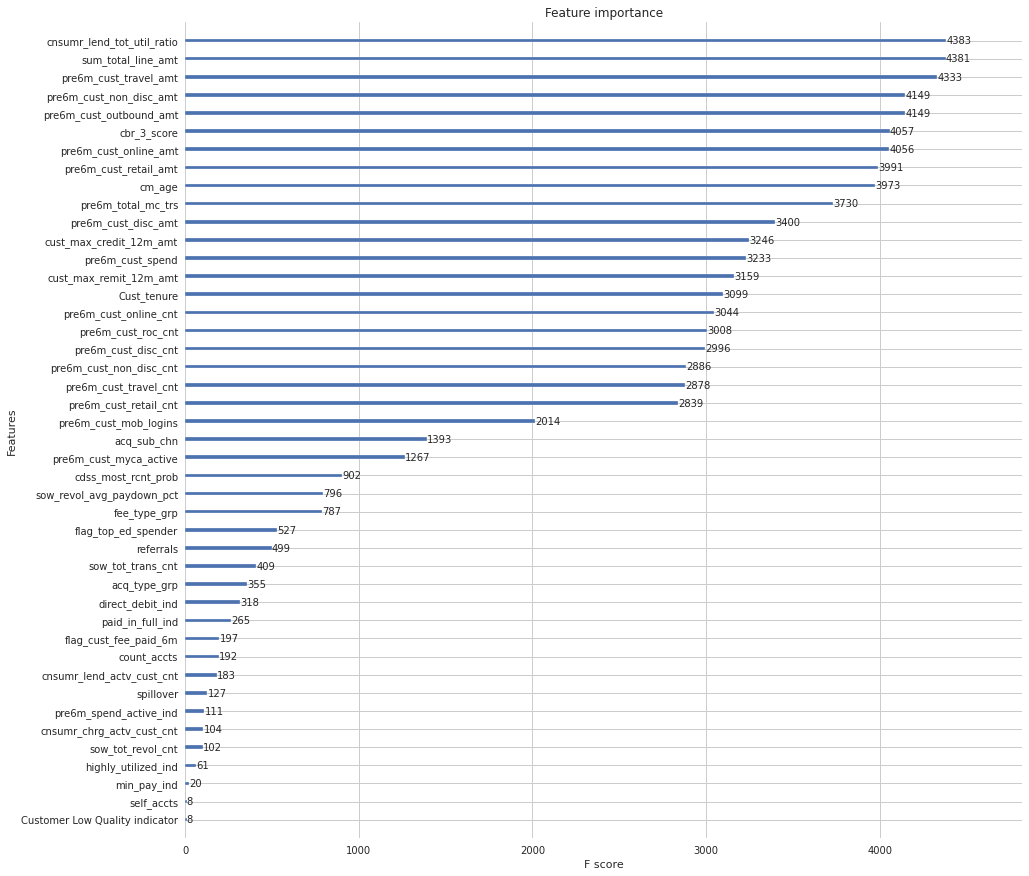

In [ ]:
xgbmodel(train_x, test_x, train_y, test_y)

In [ ]:
test_df.drop(columns = ['Customer Low Quality indicator', 'self_accts', 'min_pay_ind','highly_utilized_ind','sow_tot_revol_cnt','cnsumr_chrg_actv_cust_cnt','pre6m_spend_active_ind','spillover','cnsumr_lend_actv_cust_cnt','count_accts','flag_cust_fee_paid_6m','paid_in_full_ind', 'direct_debit_ind', 'acq_type_grp', 'referrals'], inplace = True)
train_en.drop(columns = ['Customer Low Quality indicator', 'self_accts', 'min_pay_ind','highly_utilized_ind','sow_tot_revol_cnt','cnsumr_chrg_actv_cust_cnt','pre6m_spend_active_ind','spillover','cnsumr_lend_actv_cust_cnt','count_accts','flag_cust_fee_paid_6m','paid_in_full_ind', 'direct_debit_ind', 'acq_type_grp', 'referrals'], inplace = True)

In [ ]:
xgb_features = ['cnsumr_lend_tot_util_ratio','pre6m_cust_travel_amt','pre6m_cust_outbound_amt','cbr_3_score','pre6m_cust_online_amt','pre6m_cust_non_disc_amt','pre6m_cust_retail_amt','sum_total_line_amt','pre6m_total_mc_trs','cm_age','pre6m_cust_disc_amt','cust_max_credit_12m_amt','pre6m_cust_retail_cnt','pre6m_cust_disc_cnt','pre6m_cust_roc_cnt','pre6m_cust_mob_logins']
len(xgb_features)

16

In [ ]:
# with oversampling
train_x, test_x, train_y, test_y = splitws(normalize(x_txgb), y_txgb)
print(train_x.shape, train_y.shape)
train_xs, train_ys = oversample(train_x, train_y)
print(train_xs.shape, train_ys.shape)
print(test_x.shape, test_y.shape)

(15676, 44) (15676,)
(25522, 44) (25522,)
(3919, 44) (3919,)


### Feature Creation

In [ ]:
train_en['save_p12'] = train_en['cust_max_credit_12m_amt'] - train_en['cust_max_remit_12m_amt']
train_en['sp_pr_tr6'] = train_en['pre6m_cust_spend']/(train_en['pre6m_cust_roc_cnt']+0.00001)
train_en['nd_pr_tr6'] = train_en['pre6m_cust_non_disc_amt']/(train_en['pre6m_cust_non_disc_cnt']+0.00001)
train_en['d_pr_tr6'] = train_en['pre6m_cust_disc_amt']/(train_en['pre6m_cust_disc_cnt']+0.00001)
train_en['o_pr_tr6'] = train_en['pre6m_cust_online_amt']/(train_en['pre6m_cust_online_cnt']+0.00001)
train_en['re_pr_tr6'] = train_en['pre6m_cust_retail_amt']/(train_en['pre6m_cust_retail_cnt']+0.00001)

In [ ]:
test_df['save_p12'] = test_df['cust_max_credit_12m_amt'] - test_df['cust_max_remit_12m_amt']
test_df['sp_pr_tr6'] = test_df['pre6m_cust_spend']/(test_df['pre6m_cust_roc_cnt']+0.00001)
test_df['nd_pr_tr6'] = test_df['pre6m_cust_non_disc_amt']/(test_df['pre6m_cust_non_disc_cnt']+0.00001)
test_df['d_pr_tr6'] = test_df['pre6m_cust_disc_amt']/(test_df['pre6m_cust_disc_cnt']+0.00001)
test_df['o_pr_tr6'] = test_df['pre6m_cust_online_amt']/(test_df['pre6m_cust_online_cnt']+0.00001)
test_df['re_pr_tr6'] = test_df['pre6m_cust_retail_amt']/(test_df['pre6m_cust_retail_cnt']+0.00001)

In [ ]:
new_fea = ['save_p12', 'limit_val', 'sp_pr_tr6', 'nd_pr_tr6','d_pr_tr6','o_pr_tr6', 'tr_pr_tr6', 're_pr_tr6']

Training :0.9999362082163817
Test :0.7877009441183975
ROC_AUC :0.5214241177204141
f1_score :0.1457905544147844
recall_score :0.09739368998628258
confusion_matrix :[[3016  174]
 [ 658   71]]
myscorer :(1180, 832)


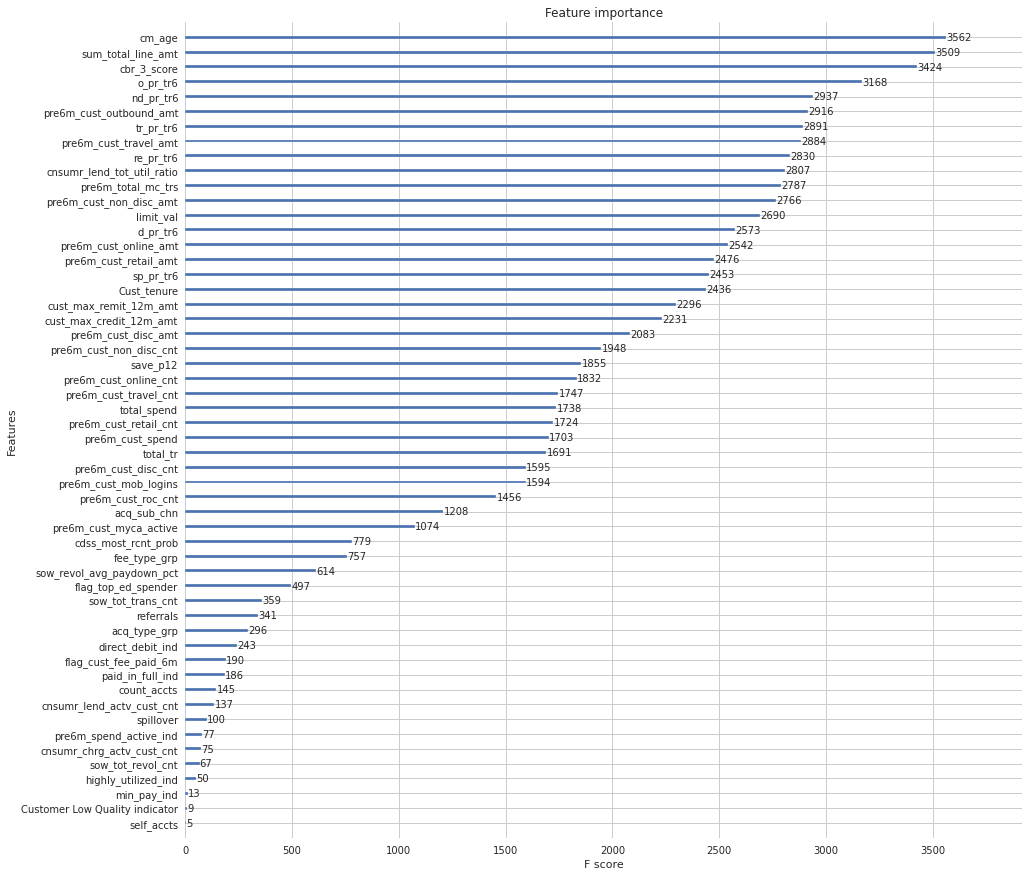

In [ ]:
xgbmodel(train_x, test_x, train_y, test_y)

Training :0.9994896657310538
Test :0.7882112783873437
ROC_AUC :0.5196210723669217
f1_score :0.1390041493775934
recall_score :0.09190672153635117
confusion_matrix :[[3022  168]
 [ 662   67]]
myscorer :(1166, 830)


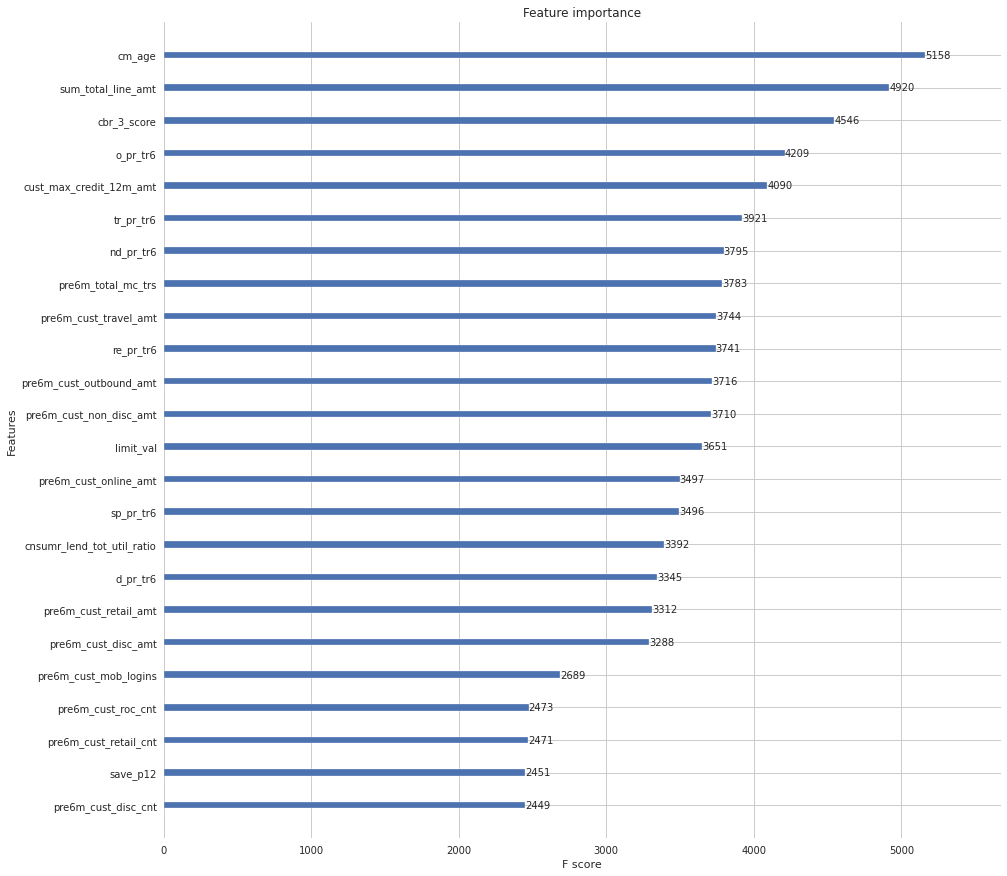

In [ ]:
xgbmodel(train_x, test_x, train_y, test_y)

In [ ]:
#splitting
x0 = train_en[train_en['profitable_flag']==0].sample(frac=1)
x1 = train_en[train_en['profitable_flag']==1].sample(frac=1)
x1.shape, x0.shape


((3644, 37), (15951, 37))

In [ ]:
x_t0 = x0[:int(len(x0)*0.3)]
x_tt0 = x0[int(len(x0)*0.3):]
x_t1 = x1[:int(len(x1)*0.07)]
x_tt1 = x1[int(len(x1)*0.07):]

In [ ]:
x_t0.shape, x_tt0.shape, x_t1.shape, x_tt1.shape

((4785, 37), (11166, 37), (255, 37), (3389, 37))

In [ ]:
train = pd.concat([x_tt0, x_tt1])
valid = pd.concat([x_t0, x_t1])
train.shape, valid.shape

((14555, 37), (5040, 37))

In [ ]:
X_train = train.drop(columns = ['cust_id', 'profitable_flag'])
y_train = train['profitable_flag']
X_valid = valid.drop(columns = ['cust_id', 'profitable_flag'])
y_valid = valid['profitable_flag']
print(X_train.shape, y_train.shape)

(14555, 35) (14555,)


In [ ]:
X_norm = normalize(X_train)


In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE();
xs_train, ys_train = sm.fit_resample(X_norm, y_train)


In [ ]:
xgb = XGBClassifier(
    learning_rate =0.08,
    n_estimators=6500,
    max_depth=5,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.7,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=3,
    scale_pos_weight=1,
    eval_metric = 'aucpr',
    seed=27)



In [ ]:
xgb.fit(xs_train, ys_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='aucpr',
              gamma=0.1, learning_rate=0.08, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=6500, n_jobs=1,
              nthread=3, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.7, verbosity=1)

In [ ]:
y_p = xgb.predict(X_valid.values)
f1_score(y_p, y_valid)

0.12795549374130735

In [ ]:
print("f1_score : ", f1_score(y_p, y_valid))
print("accuracy_score : ", accuracy_score(y_p, y_valid))
print("roc_auc_score : ", roc_auc_score(y_p, y_valid))
print("confusion_matric : ", confusion_matrix(y_p, y_valid))

f1_score :  0.12795549374130735
accuracy_score :  0.8755952380952381
roc_auc_score :  0.5267324270557029
confusion_matric :  [[4367  209]
 [ 418   46]]


In [ ]:
y_p_t = xgb.predict(test_df.values)
test['result'] = y_p_t

In [ ]:
submission = test[['cust_id', 'result']]

In [ ]:
submission.to_csv('submission.csv', header=False)

In [ ]:
test.shape, submission.shape

((5000, 50), (5000, 2))

## Model Selection

In [ ]:
# voting classifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
def ensemble():
    clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
    clf2 = RandomForestClassifier(n_estimators=65, random_state=1)
    clf3 = GradientBoostingClassifier(n_estimators=65)
    clf4 = SVC()
    eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('svm', clf4)], voting='hard')
    return eclf1


In [ ]:
clf = ensemble()

In [ ]:
clf.fit(train_final.values, target_final.values)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='multinomial',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1, solver='lbfgs',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=Non...
                                        

In [ ]:
y_pred = clf.predict(train_final.values)
accuracy_score(y_pred, target_final)

0.8144424598111764

In [ ]:
y_p = clf.predict(x_t)
f1_score(y_p, target_final)

## Model Evaluation

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
clf  = GradientBoostingClassifier(n_estimators=2000)


In [ ]:
clf.fit(xs_train, ys_train)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
print("Training Score :",clf.score(xs_train, ys_train))

Training Score : 0.9481461579795809


In [ ]:
y_pred = clf.predict(X_valid.values)
f1_score(y_valid, y_pred)

0.11650485436893204

### Test Set

In [ ]:
test.head()

,cust_id,count_accts,cm_age,flag_top_ed_spender,flag_cust_fee_paid_6m,pre6m_cust_spend,pre6m_cust_roc_cnt,pre6m_cust_non_disc_amt,pre6m_cust_non_disc_cnt,pre6m_cust_disc_amt,pre6m_cust_disc_cnt,pre6m_cust_outbound_amt,pre6m_cust_online_amt,pre6m_cust_online_cnt,pre6m_cust_travel_amt,pre6m_cust_travel_cnt,pre6m_cust_retail_amt,pre6m_cust_retail_cnt,pre6m_cust_myca_active,pre6m_cust_mob_logins,pre6m_total_mc_trs,acq_sub_chn,acq_type_grp,fee_type_grp,Cust_tenure,pre6m_spend_active_ind,highly_utilized_ind,min_pay_ind,paid_in_full_ind,sum_total_line_amt,direct_debit_ind,referrals,spillover,self_accts,Customer Low Quality indicator,cdss_most_rcnt_prob,cust_max_credit_12m_amt,cust_max_remit_12m_amt,cbr_3_score,cnsumr_chrg_actv_cust_cnt,cnsumr_chrg_avg_credit_12m_amt,cnsumr_lend_actv_cust_cnt,cnsumr_lend_tot_util_ratio,sow_revol_avg_paydown_pct,sow_tot_annual_ext_pmt_amt,sow_tot_revol_bal_amt,sow_tot_revol_cnt,sow_tot_trans_bal_amt,sow_tot_trans_cnt
0,569986,1,37,0.0,0,"9,868",760,777,174,"9,091",586,"1,705","2,286",280,"3,219",268,"2,668",240,5,9,474,Paid Search,external,no_fee,10.0,1.0,1.0,0.0,0.0,"46,000",0.0,0.0,0.0,0.0,0.0,0.048,"1,880","1,875",833.0,0.0,-,1.0,1.055513,0.0,-,-,0.0,-,0.0
1,569987,2,33,0.0,0,-,0,-,0,-,0,-,-,0,-,0,-,0,0,0,(0),MGM,external,reduced_fee,1.0,0.0,0.0,0.0,0.0,"5,133",0.0,0.0,0.0,0.0,0.0,NaN,-,-,NaN,NaN,-,NaN,NaN,NaN,-,-,NaN,-,NaN
2,569988,2,40,1.0,0,"2,401",302,"1,045",166,"1,357",136,289,483,96,220,18,986,176,5,5,2,MGM,spillover,no_fee,10.0,1.0,0.0,0.0,1.0,"69,600",0.0,0.0,0.0,0.0,0.0,0.000,739,618,1251.0,0.0,43,2.0,0.029297,0.0,-,-,0.0,-,0.0
3,569989,1,34,1.0,1,"9,836",856,829,190,"9,007",666,"2,104","2,545",292,"2,109",254,"1,921",274,6,20,170,MGM,external,reduced_fee,14.0,1.0,0.0,0.0,0.0,-,1.0,0.0,0.0,0.0,0.0,0.000,"1,864","1,851",1004.0,1.0,829,0.0,0.000000,0.0,-,-,0.0,-,0.0
4,569990,1,28,0.0,0,"2,351",260,584,90,"1,767",170,63,282,56,127,26,"1,878",124,3,3,(9),MGM,external,no_fee,7.0,1.0,0.0,0.0,1.0,"9,600",0.0,0.0,0.0,0.0,0.0,0.000,752,731,1293.0,0.0,-,1.0,0.200658,0.0,-,-,0.0,-,0.0


In [ ]:
test.isnull().sum()

cust_id                             0
count_accts                         0
cm_age                              0
flag_top_ed_spender                15
flag_cust_fee_paid_6m               0
pre6m_cust_spend                    0
pre6m_cust_roc_cnt                  0
pre6m_cust_non_disc_amt             0
pre6m_cust_non_disc_cnt             0
pre6m_cust_disc_amt                 0
pre6m_cust_disc_cnt                 0
pre6m_cust_outbound_amt             0
pre6m_cust_online_amt               0
pre6m_cust_online_cnt               0
pre6m_cust_travel_amt               0
pre6m_cust_travel_cnt               0
pre6m_cust_retail_amt               0
pre6m_cust_retail_cnt               0
pre6m_cust_myca_active              0
pre6m_cust_mob_logins               0
pre6m_total_mc_trs                  0
acq_sub_chn                       151
acq_type_grp                      142
fee_type_grp                        0
Cust_tenure                        78
pre6m_spend_active_ind             78
highly_utili

In [ ]:
test.drop(columns = missing_cols, inplace=True)

cust_id                              0
profitable_flag                      0
count_accts                          0
cm_age                               0
flag_top_ed_spender                 48
flag_cust_fee_paid_6m                0
pre6m_cust_spend                   615
pre6m_cust_roc_cnt                   0
pre6m_cust_non_disc_amt           1192
pre6m_cust_non_disc_cnt              0
pre6m_cust_disc_amt                725
pre6m_cust_disc_cnt                  0
pre6m_cust_outbound_amt           2246
pre6m_cust_online_amt             1249
pre6m_cust_online_cnt                0
pre6m_cust_travel_amt             1974
pre6m_cust_travel_cnt                0
pre6m_cust_retail_amt              854
pre6m_cust_retail_cnt                0
pre6m_cust_myca_active               0
pre6m_cust_mob_logins                0
pre6m_total_mc_trs                   0
acq_sub_chn                        902
acq_type_grp                       872
fee_type_grp                         0
Cust_tenure              

In [ ]:
# we have 3 categorical columns
cat_col = ['acq_sub_chn', 'acq_type_grp', 'fee_type_grp']
test['fee_type_grp']  =test['fee_type_grp'].map({'no_fee':0, 'full_fee':2, 'reduced_fee':1, 'unknown':-1})
test[cat_col[0]] = test[cat_col[0]].map({'MGM':0, 'Unreferred':1, 'Affiliates':2, 'In House':3,'Paid Search':4, 'Direct':5, 'Media':6, 'Search':-2,'Interactive':-2, 'Non-PDB (Personalized)':-2, 'Email':-2, 'Partnerships - Other':-2,'Outsourced':-2, 'Natural Referral':-2, 'PDB (Personalized)':-2, 'E-Mails':-2, 'Outbound':-2, 'Unaddressed':-2, 'Natural Search':-2, 'DM':-2, 'Proprietary - Direct Sales':-2})

In [ ]:
test.head()

,cust_id,count_accts,cm_age,flag_top_ed_spender,flag_cust_fee_paid_6m,pre6m_cust_spend,pre6m_cust_roc_cnt,pre6m_cust_non_disc_amt,pre6m_cust_non_disc_cnt,pre6m_cust_disc_amt,pre6m_cust_disc_cnt,pre6m_cust_outbound_amt,pre6m_cust_online_amt,pre6m_cust_online_cnt,pre6m_cust_travel_amt,pre6m_cust_travel_cnt,pre6m_cust_retail_amt,pre6m_cust_retail_cnt,pre6m_cust_myca_active,pre6m_cust_mob_logins,pre6m_total_mc_trs,acq_sub_chn,acq_type_grp,fee_type_grp,Cust_tenure,pre6m_spend_active_ind,highly_utilized_ind,min_pay_ind,paid_in_full_ind,sum_total_line_amt,direct_debit_ind,referrals,spillover,self_accts,Customer Low Quality indicator,cdss_most_rcnt_prob,cust_max_credit_12m_amt,cust_max_remit_12m_amt,cbr_3_score,cnsumr_chrg_actv_cust_cnt,cnsumr_lend_actv_cust_cnt,cnsumr_lend_tot_util_ratio,sow_revol_avg_paydown_pct,sow_tot_revol_cnt,sow_tot_trans_cnt
0,569986,1,37,0.0,0,"9,868",760,777,174,"9,091",586,"1,705","2,286",280,"3,219",268,"2,668",240,5,9,474,NaN,external,NaN,10.0,1.0,1.0,0.0,0.0,"46,000",0.0,0.0,0.0,0.0,0.0,0.048,"1,880","1,875",833.0,0.0,1.0,1.055513,0.0,0.0,0.0
1,569987,2,33,0.0,0,-,0,-,0,-,0,-,-,0,-,0,-,0,0,0,(0),NaN,external,NaN,1.0,0.0,0.0,0.0,0.0,"5,133",0.0,0.0,0.0,0.0,0.0,NaN,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,569988,2,40,1.0,0,"2,401",302,"1,045",166,"1,357",136,289,483,96,220,18,986,176,5,5,2,NaN,spillover,NaN,10.0,1.0,0.0,0.0,1.0,"69,600",0.0,0.0,0.0,0.0,0.0,0.000,739,618,1251.0,0.0,2.0,0.029297,0.0,0.0,0.0
3,569989,1,34,1.0,1,"9,836",856,829,190,"9,007",666,"2,104","2,545",292,"2,109",254,"1,921",274,6,20,170,NaN,external,NaN,14.0,1.0,0.0,0.0,0.0,-,1.0,0.0,0.0,0.0,0.0,0.000,"1,864","1,851",1004.0,1.0,0.0,0.000000,0.0,0.0,0.0
4,569990,1,28,0.0,0,"2,351",260,584,90,"1,767",170,63,282,56,127,26,"1,878",124,3,3,(9),NaN,external,NaN,7.0,1.0,0.0,0.0,1.0,"9,600",0.0,0.0,0.0,0.0,0.0,0.000,752,731,1293.0,0.0,1.0,0.200658,0.0,0.0,0.0


In [ ]:
test_df